<a href="https://www.kaggle.com/code/ranayalcinkaya/a-b-test-anova?scriptVersionId=170006954" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fast-food-marketing-campaign-ab-test/WA_Marketing-Campaign.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm 

In [3]:
df = pd.read_csv('/kaggle/input/fast-food-marketing-campaign-ab-test/WA_Marketing-Campaign.csv')

In [4]:
df.head(10)

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81
5,1,Medium,2,5,2,2,34.67
6,1,Medium,2,5,2,3,27.98
7,1,Medium,2,5,2,4,27.72
8,1,Medium,3,12,1,1,44.54
9,1,Medium,3,12,1,2,37.94


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
df.describe()

,MarketID,LocationID,AgeOfStore,Promotion,week,SalesInThousands
count,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000
mean,5.715328,479.656934,8.503650,2.029197,2.500000,53.466204
std,2.877001,287.973679,6.638345,0.810729,1.119055,16.755216
min,1.000000,1.000000,1.000000,1.000000,1.000000,17.340000
25%,3.000000,216.000000,4.000000,1.000000,1.750000,42.545000
50%,6.000000,504.000000,7.000000,2.000000,2.500000,50.200000
75%,8.000000,708.000000,12.000000,3.000000,3.250000,60.477500
max,10.000000,920.000000,28.000000,3.000000,4.000000,99.650000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MarketID          548 non-null    int64  
 1   MarketSize        548 non-null    object 
 2   LocationID        548 non-null    int64  
 3   AgeOfStore        548 non-null    int64  
 4   Promotion         548 non-null    int64  
 5   week              548 non-null    int64  
 6   SalesInThousands  548 non-null    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 30.1+ KB


In [8]:
df.nunique()

MarketID             10
MarketSize            3
LocationID          137
AgeOfStore           25
Promotion             3
week                  4
SalesInThousands    517
dtype: int64

In [9]:
market_dist = df['MarketSize'].value_counts(normalize=True)
market_dist

MarketSize
Medium    0.583942
Large     0.306569
Small     0.109489
Name: proportion, dtype: float64

In [10]:
df.groupby('MarketSize')['LocationID'].count()

MarketSize
Large     168
Medium    320
Small      60
Name: LocationID, dtype: int64

In [11]:
df.groupby(['Promotion','MarketSize'])['SalesInThousands'].mean().reset_index()

,Promotion,MarketSize,SalesInThousands
0,1,Large,75.235893
1,1,Medium,47.672604
2,1,Small,60.162500
3,2,Large,60.322031
4,2,Medium,39.114352
5,2,Small,50.810625
6,3,Large,77.203958
7,3,Medium,45.468879
8,3,Small,59.514167


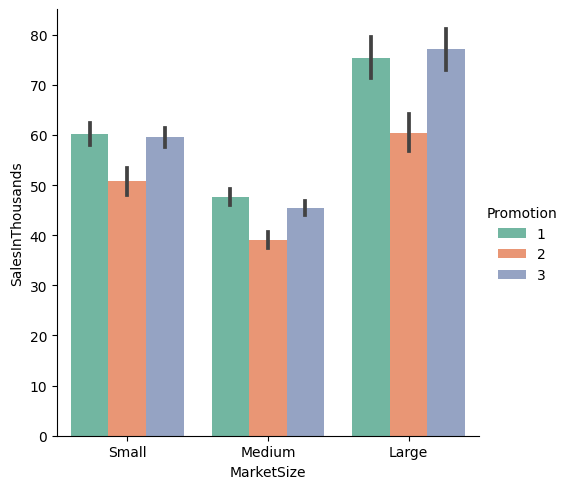

In [12]:
g = sns.catplot(
    data=df, kind="bar",
    x="MarketSize", y="SalesInThousands", hue="Promotion", order=['Small', 'Medium', 'Large'],
    errorbar="ci",palette='Set2')

In [13]:
df.groupby("Promotion").agg({"SalesInThousands":["mean","sum"]})

SalesInThousands          
                      mean       sum
Promotion                           
1                58.099012   9993.03
2                47.329415   8897.93
3                55.364468  10408.52

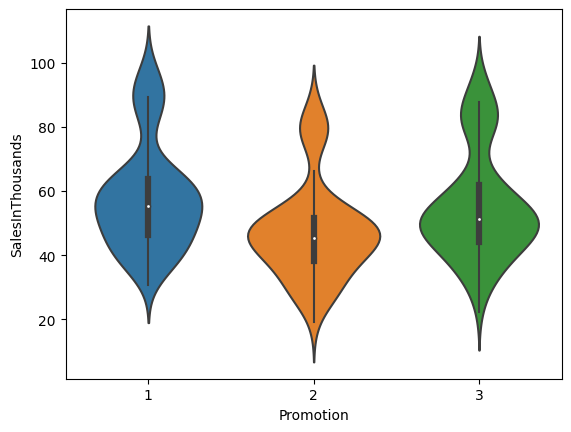

In [14]:
sns.violinplot(data=df, x='Promotion', y='SalesInThousands')
plt.show()

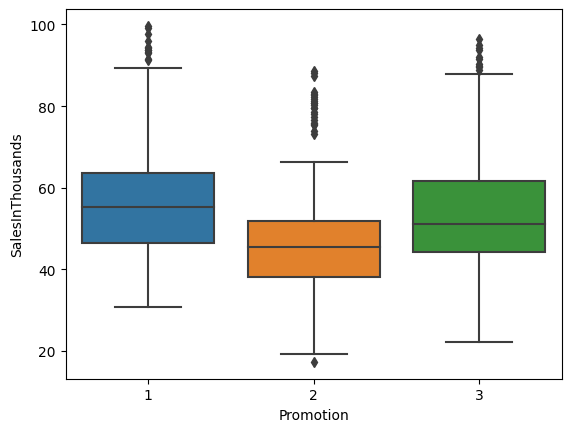

In [15]:
sns.boxplot(data=df, x='Promotion', y='SalesInThousands')
plt.show()

In [16]:
promo1 = df[df['Promotion']==1]
promo2 = df[df['Promotion']==2]
promo3 = df[df['Promotion']==3]

In [17]:
def outliers(df):
    q1 = df['SalesInThousands'].quantile(0.25)
    q3 = df['SalesInThousands'].quantile(0.75)
    
    IQR = q3 - q1

    lower_limit = q1 - (1.5 * IQR)
    upper_limit = q3 + (1.5 * IQR)
    print(lower_limit,upper_limit)
    outliers = df[(df['SalesInThousands'] < lower_limit) | (df['SalesInThousands'] > upper_limit)]
    return outliers

In [18]:
print(outliers(promo1).shape[0])
print(outliers(promo2).shape[0])
print(outliers(promo3).shape[0])

20.455000000000016 89.51499999999999
12
17.807500000000008 72.10749999999999
24
17.89500000000001 88.035
10


In [19]:
def remove_outliers(df):
    q1 = df['SalesInThousands'].quantile(0.25)
    q3 = df['SalesInThousands'].quantile(0.75)
    
    IQR = q3 - q1

    lower_limit = q1 - 1.5 * IQR
    upper_limit = q3 + 1.5 * IQR
    print(lower_limit,upper_limit)

    remained = df[(df['SalesInThousands'] >= lower_limit) & (df['SalesInThousands'] <= upper_limit)]
    print("Number of rows after filtering:", len(remained))
    return remained

In [20]:
promo3.sort_values('SalesInThousands', ascending=False)

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
104,3,Large,208,1,3,1,96.48
136,3,Large,216,4,3,1,94.89
103,3,Large,207,1,3,4,94.21
138,3,Large,216,4,3,3,93.63
106,3,Large,208,1,3,3,91.98
...,...,...,...,...,...,...,...
291,6,Medium,508,5,3,4,29.12
2,1,Medium,1,4,3,3,29.03
23,1,Medium,6,10,3,4,26.68
260,6,Medium,501,6,3,1,24.75


In [21]:
promo1_clean = remove_outliers(promo1)
promo2_clean = remove_outliers(promo2)
promo3_clean = remove_outliers(promo3)

20.455000000000016 89.51499999999999
Number of rows after filtering: 160
17.807500000000008 72.10749999999999
Number of rows after filtering: 164
17.89500000000001 88.035
Number of rows after filtering: 178


In [22]:
promo3_clean.sort_values('SalesInThousands', ascending=False)

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
121,3,Large,212,3,3,2,87.90
100,3,Large,207,1,3,1,87.70
76,3,Large,201,4,3,1,86.14
142,3,Large,217,5,3,3,86.11
94,3,Large,205,19,3,3,85.18
...,...,...,...,...,...,...,...
291,6,Medium,508,5,3,4,29.12
2,1,Medium,1,4,3,3,29.03
23,1,Medium,6,10,3,4,26.68
260,6,Medium,501,6,3,1,24.75


In [23]:
df1 = []
df1 = pd.concat([promo1_clean,promo2_clean,promo3_clean], ignore_index = True)
df1.sort_values('SalesInThousands', ascending=False)

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
29,3,Large,210,19,1,4,89.44
36,3,Large,220,3,1,2,89.32
34,3,Large,218,2,1,4,89.25
24,3,Large,202,8,1,1,88.73
32,3,Large,218,2,1,2,88.64
...,...,...,...,...,...,...,...
178,1,Medium,10,5,2,3,23.93
247,6,Medium,507,5,2,4,23.44
171,1,Medium,5,10,2,4,23.35
329,1,Medium,6,10,3,2,22.18


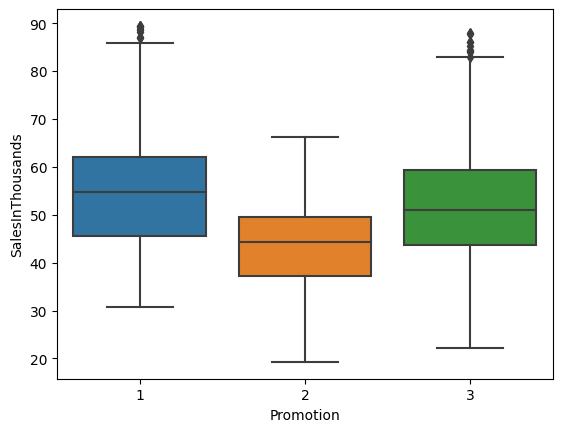

In [24]:
sns.boxplot(data=df1, x='Promotion', y='SalesInThousands')
plt.show()

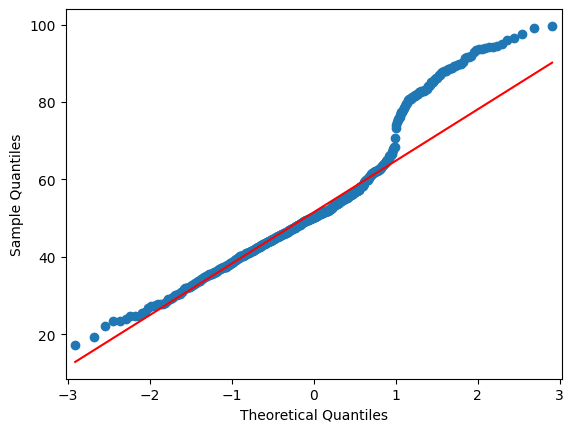

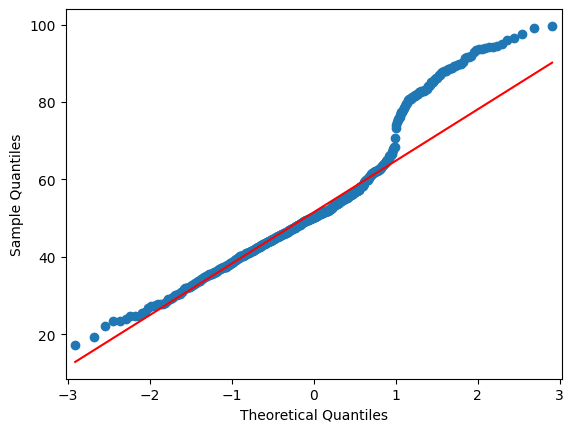

In [25]:
sm.qqplot(df['SalesInThousands'], line ='q') 

In [26]:
from scipy import stats
stats.shapiro(df['SalesInThousands'])

ShapiroResult(statistic=0.9346458911895752, pvalue=9.385896702592596e-15)

p-value is smaller than 0.05. Therefore there is no normal distribution. We will perform a non paramedric test. 

In [27]:
stats.kruskal(df1.loc[df1["Promotion"] == 1, "SalesInThousands"],
        df1.loc[df1["Promotion"] == 2, "SalesInThousands"],
        df1.loc[df1["Promotion"] == 3, "SalesInThousands"])

KruskalResult(statistic=80.06537463352375, pvalue=4.111732025490055e-18)

let's perform the test with outliers too.

In [28]:
stats.kruskal(df.loc[df["Promotion"] == 1, "SalesInThousands"],
        df.loc[df["Promotion"] == 2, "SalesInThousands"],
        df.loc[df["Promotion"] == 3, "SalesInThousands"])

KruskalResult(statistic=53.29475169322799, pvalue=2.6741866266697816e-12)

In either way, p-value is smaller than 0.05. Therefore we reject H0 so there is a statistical difference between promotions.

In [29]:
! pip install scikit-posthocs

In [30]:
import scikit_posthocs as sp
from sklearn.datasets import load_iris

data = [df1[df1['Promotion'] == 1]['SalesInThousands'],
        df1[df1['Promotion'] == 2]['SalesInThousands'],
        df1[df1['Promotion'] == 3]['SalesInThousands']]

p_values = sp.posthoc_dunn(data, p_adjust='holm')

print(p_values)

              1             2             3
1  1.000000e+00  6.508986e-17  5.167300e-02
2  6.508986e-17  1.000000e+00  2.922241e-11
3  5.167300e-02  2.922241e-11  1.000000e+00


In [31]:
print(p_values <0.05)

       1      2      3
1  False   True  False
2   True  False   True
3  False   True  False


* Group 1 is significantly different from Group 2.
* Group 2 is significantly different from Group 1 and Group 2.
* Group 3 is significantly different from Group 2.
* Group 1 and Group 3 are not significantly different.